# atmodeller

## Science Cases

Following the Monte Carlo approach in 3_monte_carlo.ipynb, we sample the possible atmospheres of known exoplanets that can arise for different planetary conditions.


In [1]:
#from atmodeller import debug_logger
from typing import Type
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet, Species
from atmodeller.constraints import MassConstraint, IronWustiteBufferConstraintHirschmann, SystemConstraints, FugacityConstraint, PressureConstraint
from atmodeller.eos.holland import (
    CO2_CORK_simple_HP91,
    CO2_MRK_simple_HP91,
    get_holland_eos_models,
)
from atmodeller.eos.saxena import (
    get_saxena_eos_models
)
from atmodeller.interfaces import (
    GasSpecies,
    IdealGas,
    NoSolubility,
    RealGasABC,
    ThermodynamicDataset,
)
from atmodeller.solubilities import PeridotiteH2O, BasaltDixonCO2, BasaltLibourelN2, BasaltDixonH2O, BasaltS2, BasaltH2, BasaltCO, BasaltLibourelN2, BasaltCH4, BasaltHe, BasaltCl2
from atmodeller.utilities import earth_oceans_to_kg
import numpy as np
import csv
from atmodeller import debug_file_logger
import logging

thermodynamic_data: Type[ThermodynamicDataset] = ThermodynamicDataset

eos_models_HP: dict[str, RealGasABC] = get_holland_eos_models()
eos_models_SS: dict[str, RealGasABC] = get_saxena_eos_models()

logger = debug_file_logger()
#logger.setLevel(logging.INFO)


In [1]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt

plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
#plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times']})
#plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)


## Simulating Trappist-1 e

In [9]:
species: Species = Species()
species.append(GasSpecies(formula='H2O', solubility=BasaltDixonH2O()))
species.append(GasSpecies(formula='H2', solubility=BasaltH2()))
species.append(GasSpecies(formula='O2'))
species.append(GasSpecies(formula='CO', solubility=BasaltCO()))
species.append(GasSpecies(formula='CO2', solubility=BasaltDixonCO2()))
species.append(GasSpecies(formula='CH4', solubility=BasaltCH4()))
species.append(GasSpecies(formula='N2', solubility=BasaltLibourelN2()))
species.append(GasSpecies(formula='S2', solubility=BasaltS2()))
species.append(GasSpecies(formula='H2S'))
species.append(GasSpecies(formula='SO2'))
species.append(GasSpecies(formula='Cl2', solubility=BasaltCl2()))
#species.append(GasSpecies(chemical_formula='He'))

species

[13:30:30 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies H2O using thermodynamic data in JANAF (JANAF name = H2O)
[13:30:30 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies H2 using thermodynamic data in JANAF (JANAF name = H2)
[13:30:30 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies O2 using thermodynamic data in JANAF (JANAF name = O2)


[13:30:30 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies CO using thermodynamic data in JANAF (JANAF name = CO)
[13:30:30 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies CO2 using thermodynamic data in JANAF (JANAF name = CO2)
[13:30:30 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies CH4 using thermodynamic data in JANAF (JANAF name = CH4)
[13:30:31 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies N2 using thermodynamic data in JANAF (JANAF name = N2)
[13:30:31 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies S2 using thermodynamic data in JANAF (JANAF name = S2)
[13:30:31 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies H2S using thermodynamic data in JANAF (JANAF name = H2S)
[13:30:31 - atmodeller.interfaces          - INFO     ] - Creating GasSpecies SO2 using thermodynamic data in JANAF (JANAF name = O2S)
[13:30:31 - atmodeller.interfaces          - INFO     ] - Cre

Species([GasSpecies(formula='H2O', thermodynamic_dataset=<atmodeller.interfaces.ThermodynamicDatasetJANAF object at 0x121b8d750>, name_in_dataset='H2O', _formula=Formula('H2O'), _thermodynamic_data=ThermodynamicDatasetJANAF.ThermodynamicDataForSpecies(species=..., data_source='JANAF', data=<thermochem.janaf.JanafPhase object at 0x121bcf010>), _output=None, solubility=<atmodeller.solubilities.BasaltDixonH2O object at 0x121b8d810>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(formula='H2', thermodynamic_dataset=<atmodeller.interfaces.ThermodynamicDatasetJANAF object at 0x1215effd0>, name_in_dataset='H2', _formula=Formula('H2'), _thermodynamic_data=ThermodynamicDatasetJANAF.ThermodynamicDataForSpecies(species=..., data_source='JANAF', data=<thermochem.janaf.JanafPhase object at 0x121bb8150>), _output=None, solubility=<atmodeller.solubilities.BasaltH2 object at 0x116e0df50>, solid_melt_dist

In [10]:
planet: Planet = Planet(surface_temperature=1500, mantle_mass = 3.249E24, surface_radius = 5.804E6, mantle_melt_fraction=1)


[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Mantle mass (kg) = 3248999999999999788187648.000000
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Mantle melt fraction = 1.000000
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Core mass fraction = 0.295335
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Planetary radius (m) = 5804000.000000
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Planetary mass (kg) = 4610699520224821698887680.000000
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Surface temperature (K) = 1500.000000
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Surface gravity (m/s^2) = 9.135193
[13:30:33 - atmodeller.interior_atmosphere - INFO     ] - Melt Composition = None


In [11]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

[13:30:35 - atmodeller.initial_condition   - INFO     ] - Creating InitialConditionConstant
[13:30:35 - atmodeller.interior_atmosphere - INFO     ] - Creating an interior-atmosphere system
[13:30:35 - atmodeller.interior_atmosphere - INFO     ] - Creating a reaction network
[13:30:35 - atmodeller.interior_atmosphere - INFO     ] - Species = ['H2O', 'H2', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'S2', 'H2S', 'SO2', 'Cl2']
[13:30:35 - atmodeller.interior_atmosphere - INFO     ] - Reactions = 
{0: '0.75 O2 + 0.5 CH4 = 1.0 H2O + 0.5 CO',
 1: '0.5 O2 + 1.0 CO = 1.0 CO2',
 2: '0.25 O2 + 0.5 CH4 + 0.5 S2 = 0.5 CO + 1.0 H2S',
 3: '1.0 O2 + 0.5 S2 = 1.0 SO2',
 4: '0.25 O2 + 0.5 CH4 = 1.0 H2 + 0.5 CO'}


### Monte Carlo Analysis 

In [12]:
#Set-up the Parameters to explore:
number_of_realisations = 100

# Parameters are normally distributed between bounds.
number_ocean_moles = np.random.uniform(1, 10, number_of_realisations)
Tsurf_arr = np.random.uniform(1000, 2000, number_of_realisations)
ch_ratios = np.random.uniform(0.1, 1, number_of_realisations)
fo2_shifts = np.random.uniform(-4, 4, number_of_realisations)
mantle_meltfrac_arr = np.random.uniform(0.1, 1, number_of_realisations)

#BSE Masses:
mass_H_BSE_min: float = 2.627E20
mass_H_BSE_max: float = 2.687E21

mass_C_BSE_min: float = 2.507E20
mass_C_BSE_max: float = 4.358E21

mass_S_BSE_min: float = 1.194E21
mass_S_BSE_max: float = 1.791E21

mass_N_BSE_min: float = 4.955E18
mass_N_BSE_max: float = 1.4925E19

mass_Cl_BSE: float = 10.4E19
mass_Cl_BSE_low: float = 10.4e18
mass_He_ATM: float = 2.677E15

print(earth_oceans_to_kg(10))

1.5500015377899478e+21


In [17]:
import pandas as pd
mass_H = earth_oceans_to_kg(8)
mass_C = mass_H*0.3
constraints: SystemConstraints = SystemConstraints([
    MassConstraint(species="H", value=mass_H),
    MassConstraint(species="C", value=mass_C),
    MassConstraint(species="S", value=mass_S_BSE_min),
    MassConstraint(species="N", value=mass_N_BSE_min),
    MassConstraint(species="Cl", value=mass_Cl_BSE),
    #MassConstraint(species="He", value=mass_He_ATM),
    IronWustiteBufferConstraintHirschmann(log10_shift=-4, pressure=1),
])
#interior_atmosphere_test: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)
interior_atmosphere_test.solve(constraints, initial_solution=[5,500, 3.582582076644303e-16,0.37295995676821214,0.0014482708908725526,21.654800815683892,0.11314982957582534, 1.6, 1e-4, 40, 1e-10])
#interior_atmosphere_test.solve(constraints)
output = interior_atmosphere_test.output()



[17:02:47 - atmodeller.interior_atmosphere - INFO     ] - Assembling constraints
[17:02:47 - atmodeller.interior_atmosphere - INFO     ] - Constraints: [MassConstraint(name='mass', species='H', value=1.2400012302319582e+21),
 MassConstraint(name='mass', species='C', value=3.720003690695874e+20),
 MassConstraint(name='mass', species='S', value=1.194e+21),
 MassConstraint(name='mass', species='N', value=4.955e+18),
 MassConstraint(name='mass', species='Cl', value=1.04e+20),
 IronWustiteBufferConstraintHirschmann(name='fugacity',
                                       species='O2',
                                       log10_shift=-4,
                                       pressure=1)]
[17:02:47 - atmodeller.interior_atmosphere - INFO     ] - 5 additional (mass) constraint(s) are necessary to solve the system
[17:02:47 - atmodeller.interior_atmosphere - INFO     ] - Apply fugacity constraint for O2
[17:02:47 - atmodeller.interior_atmosphere - INFO     ] - Row 00: Reaction 0: 0.6666666666

In [20]:
output_H2O = pd.DataFrame(data=output['H2O'].values, columns=('H2O_mass_in_atmosphere',	'H2O_mass_in_solid','H2O_mass_in_melt',	'H2O_moles_in_atmosphere',	'H2O_moles_in_melt',	
                                                              'H2O_moles_in_solid',	'H2O_ppmw_in_solid', 'H2O_ppmw_in_melt','H2O_fugacity',	'H2O_fugacity_coefficient',	'H2O_pressure', 
                                                              'H2O_volume_mixing_ratio','H2O_mass_in_total'))
output_CO2 = pd.DataFrame(data=output['CO2'].values, columns=('CO2_mass_in_atmosphere',	'CO2_mass_in_solid','CO2_mass_in_melt',	'CO2_moles_in_atmosphere','CO2_moles_in_melt',	
                                                              'CO2_moles_in_solid',	'CO2_ppmw_in_solid', 'CO2_ppmw_in_melt','CO2_fugacity',	'CO2_fugacity_coefficient',	'CO2_pressure', 
                                                              'CO2_volume_mixing_ratio','CO2_mass_in_total'))

for i in output.keys():
    print(i)
    #print(output[str(i)])
    df= pd.DataFrame(data=output[str(i)])
    print(df)
    df.to_csv('df_'+str(i)+'.csv')

filename: str = "science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_FullOutputEx.csv"

#df_try.to_csv(filename, )
#print("Writing output to: %s", filename)
#fieldnames: list[str] = list(out.keys())
#with open(filename, "w", newline="", encoding="utf-8") as csvfile:
#    writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
#    writer.writeheader()
#    writer.writerows()

solution
        H2O          H2            O2        CO       CO2        CH4  \
0  4.715361  563.001509  2.500764e-16  0.210833  0.000684  33.843939   
1  4.715361  563.001510  2.500764e-16  0.210833  0.000684  33.843939   

         N2       Cl2       S2        H2S           SO2  
0  0.194487  1.612741  0.00039  40.943091  2.999627e-09  
1  0.194487  1.612741  0.00039  40.943090  2.999627e-09  
atmosphere
   total_pressure  mean_molar_mass
0      644.523035         0.005095
1      644.523035         0.005095
constraints
         H_mass        C_mass        S_mass        N_mass       Cl_mass  \
0  1.240001e+21  3.720004e+20  1.194000e+21  4.955000e+18  1.040000e+20   
1  1.240001e+21  3.720004e+20  1.194000e+21  4.955000e+18  1.040000e+20   

    O2_fugacity  
0  2.500764e-16  
1  2.500764e-16  
planet
    mantle_mass  mantle_melt_fraction  core_mass_fraction  surface_radius  \
0  3.249000e+24                     1            0.295335       5804000.0   
1  3.249000e+24                

In [3]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

datafile_fO2: str = f"science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_1000its.csv"
df_fO2: pd.DataFrame = pd.read_csv(datafile_fO2, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO_pp', 'CO2_pp', 'CH4_pp', 'N2_pp', 'fO2_shift', 'number_ocean_moles','ch_ratio'))

#rng = np.random.default_rng()
#points = rng.random((1000, 2))
#print(points)
#values = func(points[:,0], points[:,1])

initial_sol_data = np.array([df_fO2.H2O_pp.values, df_fO2.H2_pp.values, df_fO2.O2_pp.values, df_fO2.CO_pp.values, df_fO2.CO2_pp.values, df_fO2.CH4_pp.values, df_fO2.N2_pp.values])
constraints_data = np.array([df_fO2.fO2_shift, df_fO2.number_ocean_moles, df_fO2.ch_ratio])
#print(constraints_data.T)
sample_vals = np.array([-1, 2, 0.5])
#print(sample_vals)

result = next(t for t in constraints_data.T if all (np.abs(x-y)<0.1 for x,y in zip(sample_vals, t)))
#print(result)
#df_fO2.loc[result[3]].H2O_pp


neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(constraints_data.T)
NearestNeighbors(n_neighbors=1)
closest_val =(neigh.kneighbors([sample_vals]))

close_match = closest_val[1].reshape(1,-1).flatten().tolist()
print(close_match)
print(df_fO2.loc[close_match].fO2_shift.values)
print(df_fO2.loc[180].number_ocean_moles)
print(df_fO2.loc[180].ch_ratio)


print(df_fO2.loc[180])

[998]
[-1.04402992]
6.421482572838212
0.9975953029758228
H2O_pp                2.222752e+03
H2_pp                 4.930062e+01
O2_pp                 7.246683e-09
CO_pp                 2.060270e+01
CO2_pp                3.598184e+02
CH4_pp                4.711061e-03
N2_pp                 8.139461e-01
fO2_shift             3.462067e+00
number_ocean_moles    6.421483e+00
ch_ratio              9.975953e-01
Name: 180, dtype: float64


In [ ]:
# Store the output in a list.
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_H = earth_oceans_to_kg(number_ocean_moles[realisation])
    mass_C = ch_ratios[realisation] * mass_H
    constraints: SystemConstraints = SystemConstraints([
        MassConstraint(species="H", value=mass_H),
        MassConstraint(species="C", value=mass_C),
        MassConstraint(species="S", value=mass_S_BSE_min),
        MassConstraint(species="N", value=mass_N_BSE_min),
        MassConstraint(species="Cl", value=mass_Cl_BSE),
        #MassConstraint(species="He", value=mass_He_ATM),
        IronWustiteBufferConstraintHirschmann(log10_shift=fo2_shifts[realisation], pressure=1),
    ])
    #Load dataset for initial solution:
    datafile_fO2: str = f"science_cases_files/CHONSCl/CHONSCl_HNCSSols_50/Trappist1e_IdealNoSols_MC_CHONSCl_HNCSSols_1500K_MF1_50its.csv"
    df_fO2: pd.DataFrame = pd.read_csv(datafile_fO2, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO_pp', 'CO2_pp', 'CH4_pp', 'N2_pp', 'S2_pp', 'H2S_pp', 'SO2_pp', 'Cl2_pp', 'fO2_shift', 'number_ocean_moles','ch_ratio'))

    constraints_data = np.array([df_fO2.fO2_shift, df_fO2.number_ocean_moles, df_fO2.ch_ratio])
    constraint_vals = np.array([fo2_shifts[realisation], number_ocean_moles[realisation], ch_ratios[realisation]])
    #print(constraint_vals)
    #Given current constraints, find closest match in dataset:

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(constraints_data.T)
    NearestNeighbors(n_neighbors=1)
    closest_val =(neigh.kneighbors([constraint_vals]))

    close_match = closest_val[1].reshape(1).flatten().tolist()
    initial_sol = [df_fO2.loc[close_match].H2O_pp.values[0], df_fO2.loc[close_match].H2_pp.values[0], df_fO2.loc[close_match].O2_pp.values[0], df_fO2.loc[close_match].CO_pp.values[0], 
                   df_fO2.loc[close_match].CO2_pp.values[0], df_fO2.loc[close_match].CH4_pp.values[0], df_fO2.loc[close_match].N2_pp.values[0], df_fO2.loc[close_match].S2_pp.values[0], 
                   df_fO2.loc[close_match].H2S_pp.values[0], df_fO2.loc[close_match].SO2_pp.values[0],1e-9]
    #initial_sol = [10, 10, 1e-10, 10, 10, 1, 0.1, 1e-4,10,10,10]
    
    interior_atmosphere.solve(constraints, factor=0.1, initial_solution=initial_sol)
    #interior_atmosphere.solve(constraints)
    output = interior_atmosphere.output()
    out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    #out_realisation: dict[str,float] = interior_atmosphere.output()

    # Include the parameters in the output.

    out_realisation['fo2_shift'] = fo2_shifts[realisation]
    out_realisation['number_ocean_moles'] = number_ocean_moles[realisation]
    out_realisation['ch_ratio'] = ch_ratios[realisation]
    #out_realisation['Tsurf'] = Tsurf_arr[realisation]
    #out_realisation['mantle_meltfrac'] = mantle_meltfrac_arr[realisation]

    out.append(out_realisation)

    filename: str = "science_cases_files/CHONSCl/CHONSCl_HNCSSols_50/Trappist1e_IdealNoSols_MC_CHONS_HNCSSols_1500K_MF1_50its_v2.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)

    #for i in output.keys():
    #print(output[str(i)])
        #df= pd.DataFrame(data=output[str(i)])
        #print(df)
        #df.to_csv('science_cases_files/CHONSCl/CHONSCl_HNCSClSols_50/df_'+str(i)+'.csv')


In [ ]:

    #H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    #H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    #O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    #H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    #H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    #O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    #CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    #CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    #out_realisation['H2_melt'] = H2_melt
    #out_realisation['H2O_melt'] = H2O_melt
    #out_realisation['O2_melt'] = O2_melt
    #out_realisation['CO2_melt'] = CO2_melt
    #out_realisation['CO_melt'] = CO_melt
    

In [2]:
import pandas as pd
datafile_T1e: str = f"science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_10000its.csv"
df_T1e: pd.DataFrame = pd.read_csv(datafile_T1e, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO_pp', 'CO2_pp', 'CH4_pp', 'N2_pp', 'fO2_shift', 'number_ocean_moles','ch_ratio'))

#print(df_fO2.fO2_shift)


/var/folders/48/rykhh41s6ds_xk4143_5pyv00000gn/T/ipykernel_19160/4080650116.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


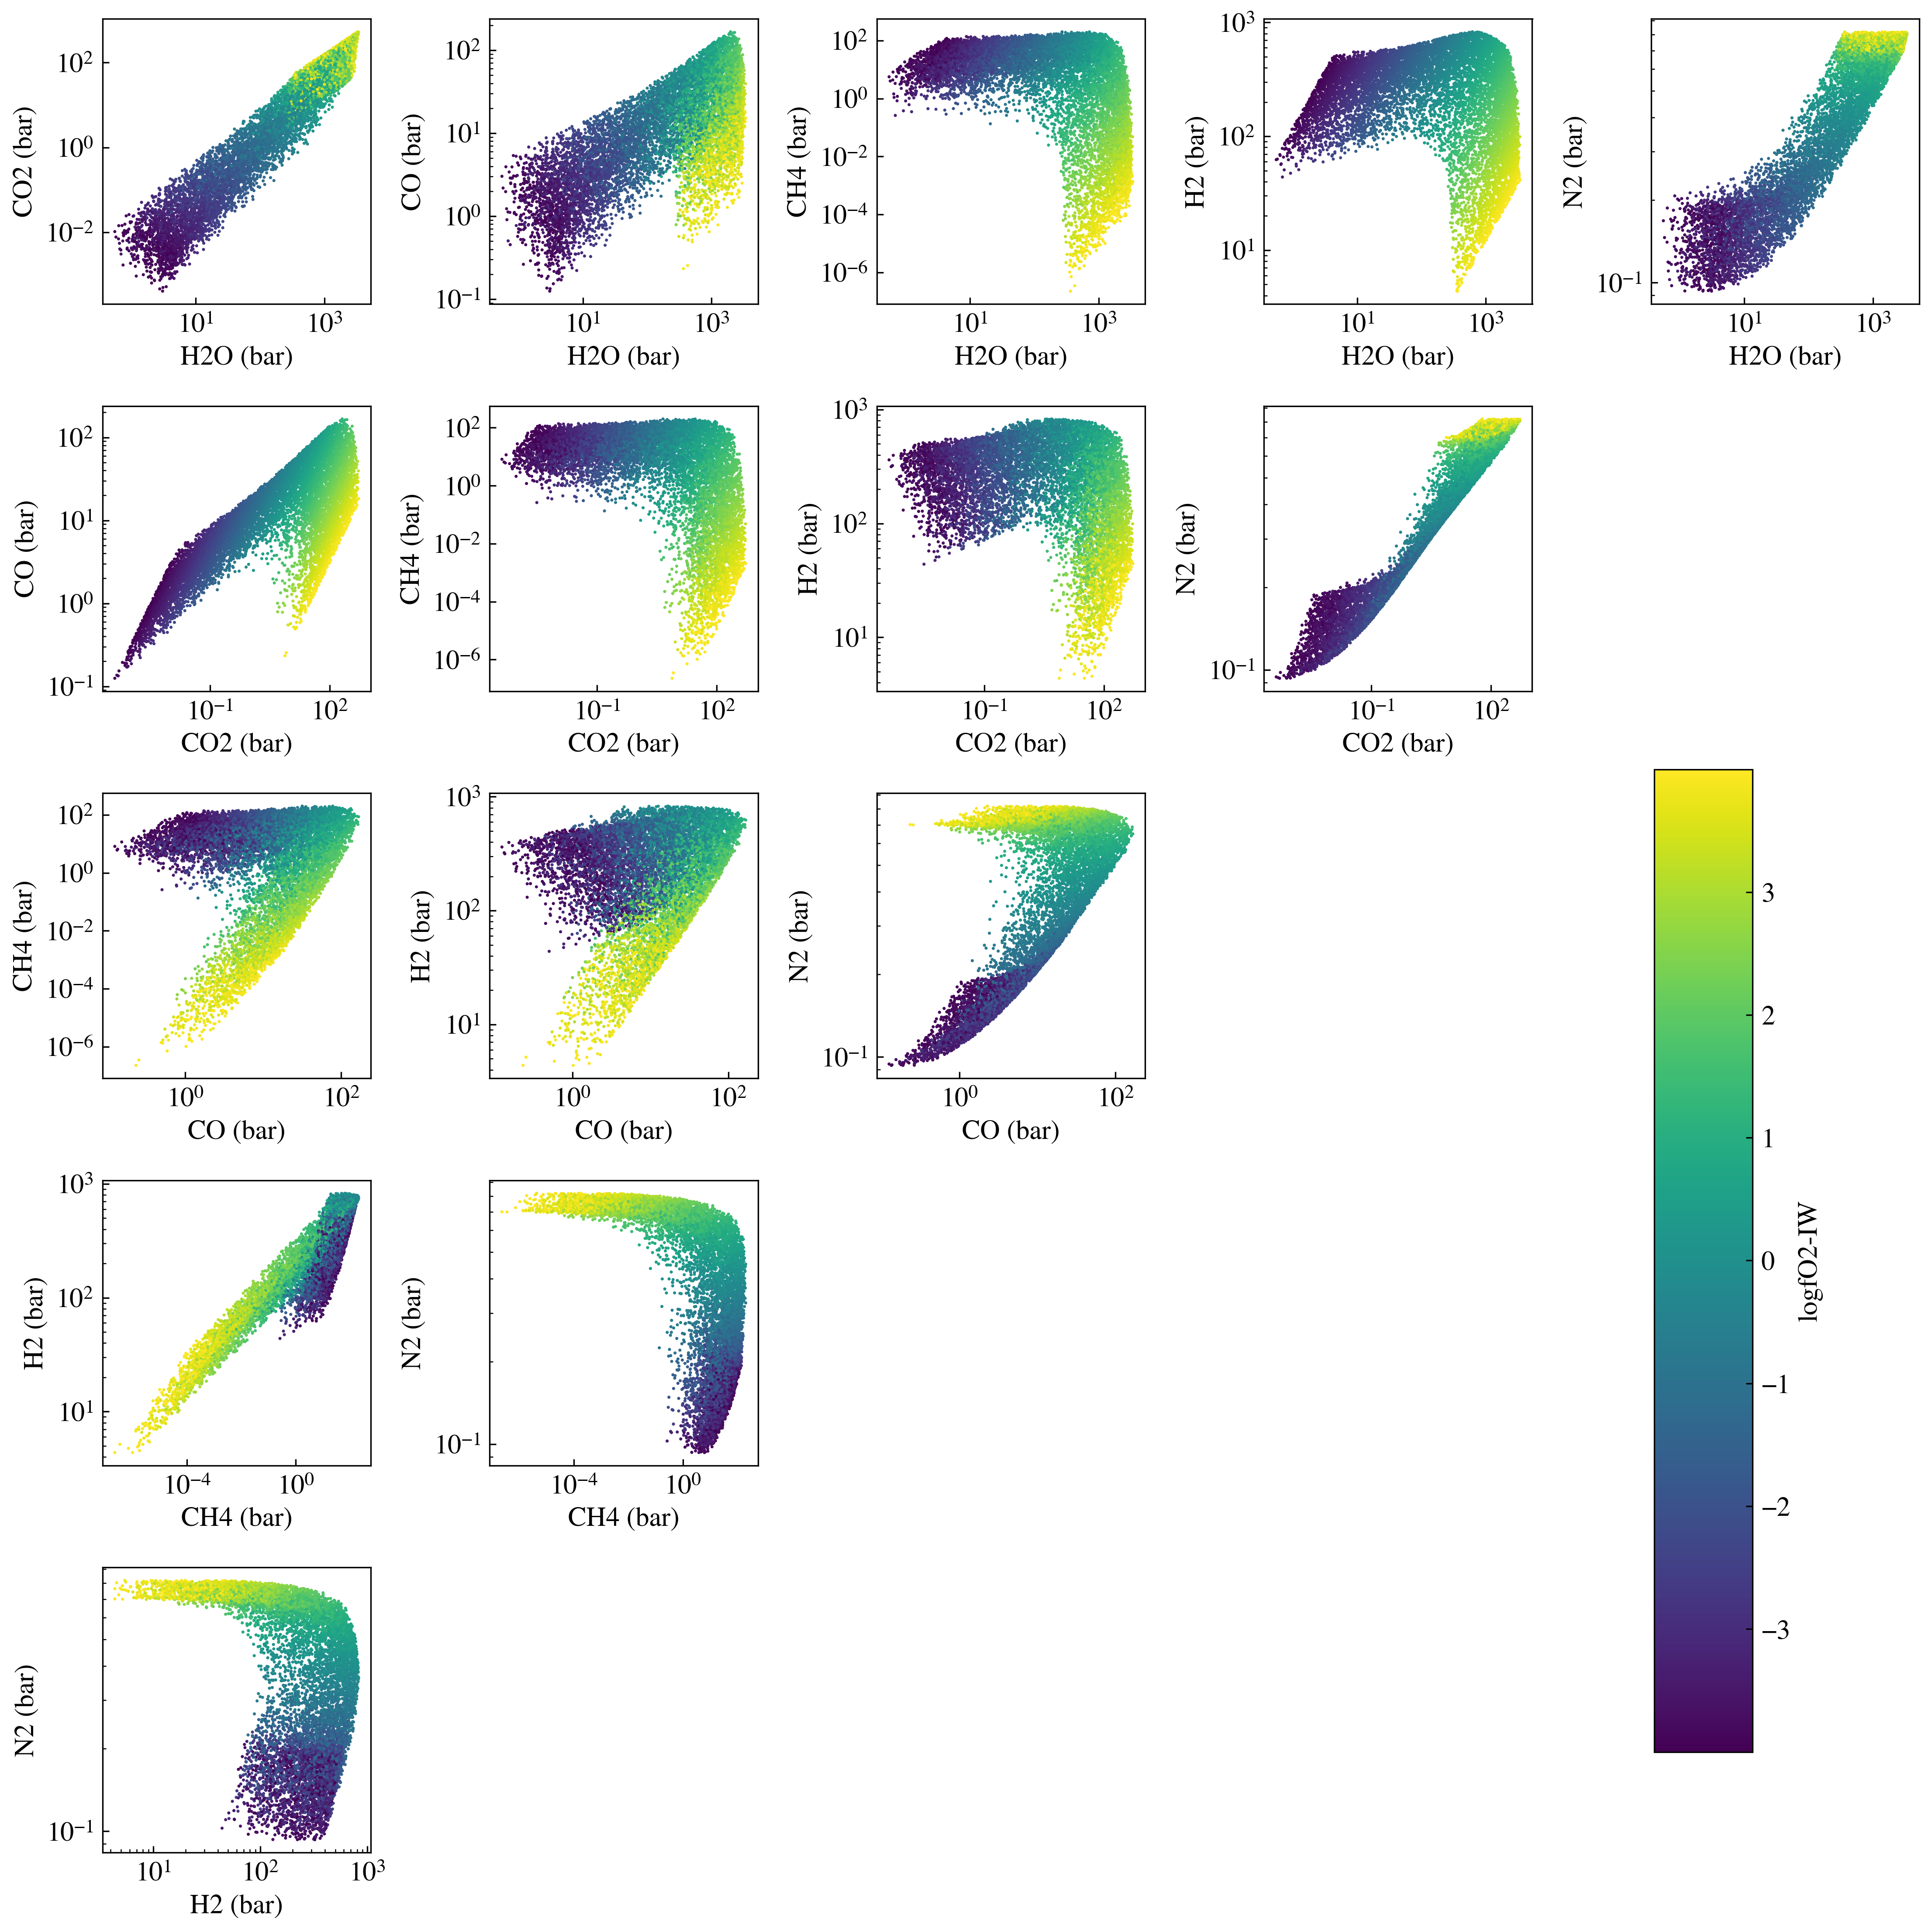

In [3]:

fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows=5)

#colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=df_T1e.fO2_shift
#H2O-CO2
ax[0,0].scatter(df_T1e.H2O_pp, df_T1e.CO2_pp, c=colors, s=0.5)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('H2O (bar)')
ax[0,0].set_ylabel('CO2 (bar)')

#H2O-CO
ax[0,1].scatter(df_T1e.H2O_pp, df_T1e.CO_pp, c=colors, s=0.5)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('H2O (bar)')
ax[0,1].set_ylabel('CO (bar)')

#H2O-CH4
ax[0,2].scatter(df_T1e.H2O_pp, df_T1e.CH4_pp, c=colors, s=0.5)
ax[0,2].set_xscale('log')
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('H2O (bar)')
ax[0,2].set_ylabel('CH4 (bar)')

#H2O-H2
ax[0,3].scatter(df_T1e.H2O_pp, df_T1e.H2_pp, c=colors, s=0.5)
ax[0,3].set_xscale('log')
ax[0,3].set_yscale('log')
ax[0,3].set_xlabel('H2O (bar)')
ax[0,3].set_ylabel('H2 (bar)')

#H2O-N2
ax[0,4].scatter(df_T1e.H2O_pp, df_T1e.N2_pp, c=colors, s=0.5)
ax[0,4].set_xscale('log')
ax[0,4].set_yscale('log')
ax[0,4].set_xlabel('H2O (bar)')
ax[0,4].set_ylabel('N2 (bar)')

#CO2-CO
ax[1,0].scatter(df_T1e.CO2_pp, df_T1e.CO_pp, c=colors, s=0.5)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('CO2 (bar)')
ax[1,0].set_ylabel('CO (bar)')

#CO2-CH4
ax[1,1].scatter(df_T1e.CO2_pp, df_T1e.CH4_pp, c=colors, s=0.5)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('CO2 (bar)')
ax[1,1].set_ylabel('CH4 (bar)')

#CO2-H2
ax[1,2].scatter(df_T1e.CO2_pp, df_T1e.H2_pp, c=colors, s=0.5)
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')
ax[1,2].set_xlabel('CO2 (bar)')
ax[1,2].set_ylabel('H2 (bar)')

#CO2-N2
ax[1,3].scatter(df_T1e.CO2_pp, df_T1e.N2_pp, c=colors, s=0.5)
ax[1,3].set_xscale('log')
ax[1,3].set_yscale('log')
ax[1,3].set_xlabel('CO2 (bar)')
ax[1,3].set_ylabel('N2 (bar)')

#CO-CH4
ax[2,0].scatter(df_T1e.CO_pp, df_T1e.CH4_pp, c=colors, s=0.5)
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
ax[2,0].set_xlabel('CO (bar)')
ax[2,0].set_ylabel('CH4 (bar)')

#CO-H2
ax[2,1].scatter(df_T1e.CO_pp, df_T1e.H2_pp, c=colors, s=0.5)
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')
ax[2,1].set_xlabel('CO (bar)')
ax[2,1].set_ylabel('H2 (bar)')

#CO-N2
ax[2,2].scatter(df_T1e.CO_pp, df_T1e.N2_pp, c=colors, s=0.5)
ax[2,2].set_xscale('log')
ax[2,2].set_yscale('log')
ax[2,2].set_xlabel('CO (bar)')
ax[2,2].set_ylabel('N2 (bar)')

#CH4-H2
ax[3,0].scatter(df_T1e.CH4_pp, df_T1e.H2_pp, c=colors, s=0.5)
ax[3,0].set_xscale('log')
ax[3,0].set_yscale('log')
ax[3,0].set_xlabel('CH4 (bar)')
ax[3,0].set_ylabel('H2 (bar)')

#CH4-N2
ax[3,1].scatter(df_T1e.CH4_pp, df_T1e.N2_pp, c=colors, s=0.5)
ax[3,1].set_xscale('log')
ax[3,1].set_yscale('log')
ax[3,1].set_xlabel('CH4 (bar)')
ax[3,1].set_ylabel('N2 (bar)')

#H2-N2
sc = ax[4,0].scatter(df_T1e.H2_pp, df_T1e.N2_pp, c=colors, s=0.5)
ax[4,0].set_xscale('log')
ax[4,0].set_yscale('log')
ax[4,0].set_xlabel('H2 (bar)')
ax[4,0].set_ylabel('N2 (bar)')

ax[1, 4].axis('off')
ax[2, 3].axis('off')
ax[2, 4].axis('off')
ax[3, 2].axis('off')
ax[3, 3].axis('off')
ax[3, 4].axis('off')
ax[4, 1].axis('off')
ax[4, 2].axis('off')
ax[4, 3].axis('off')
ax[4, 4].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.05, 0.5])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')

fig.tight_layout()
#plt.savefig("Plots/T1e_HCON_1500K_MF1_10000its_logscale.jpg", dpi=1000)
plt.show()

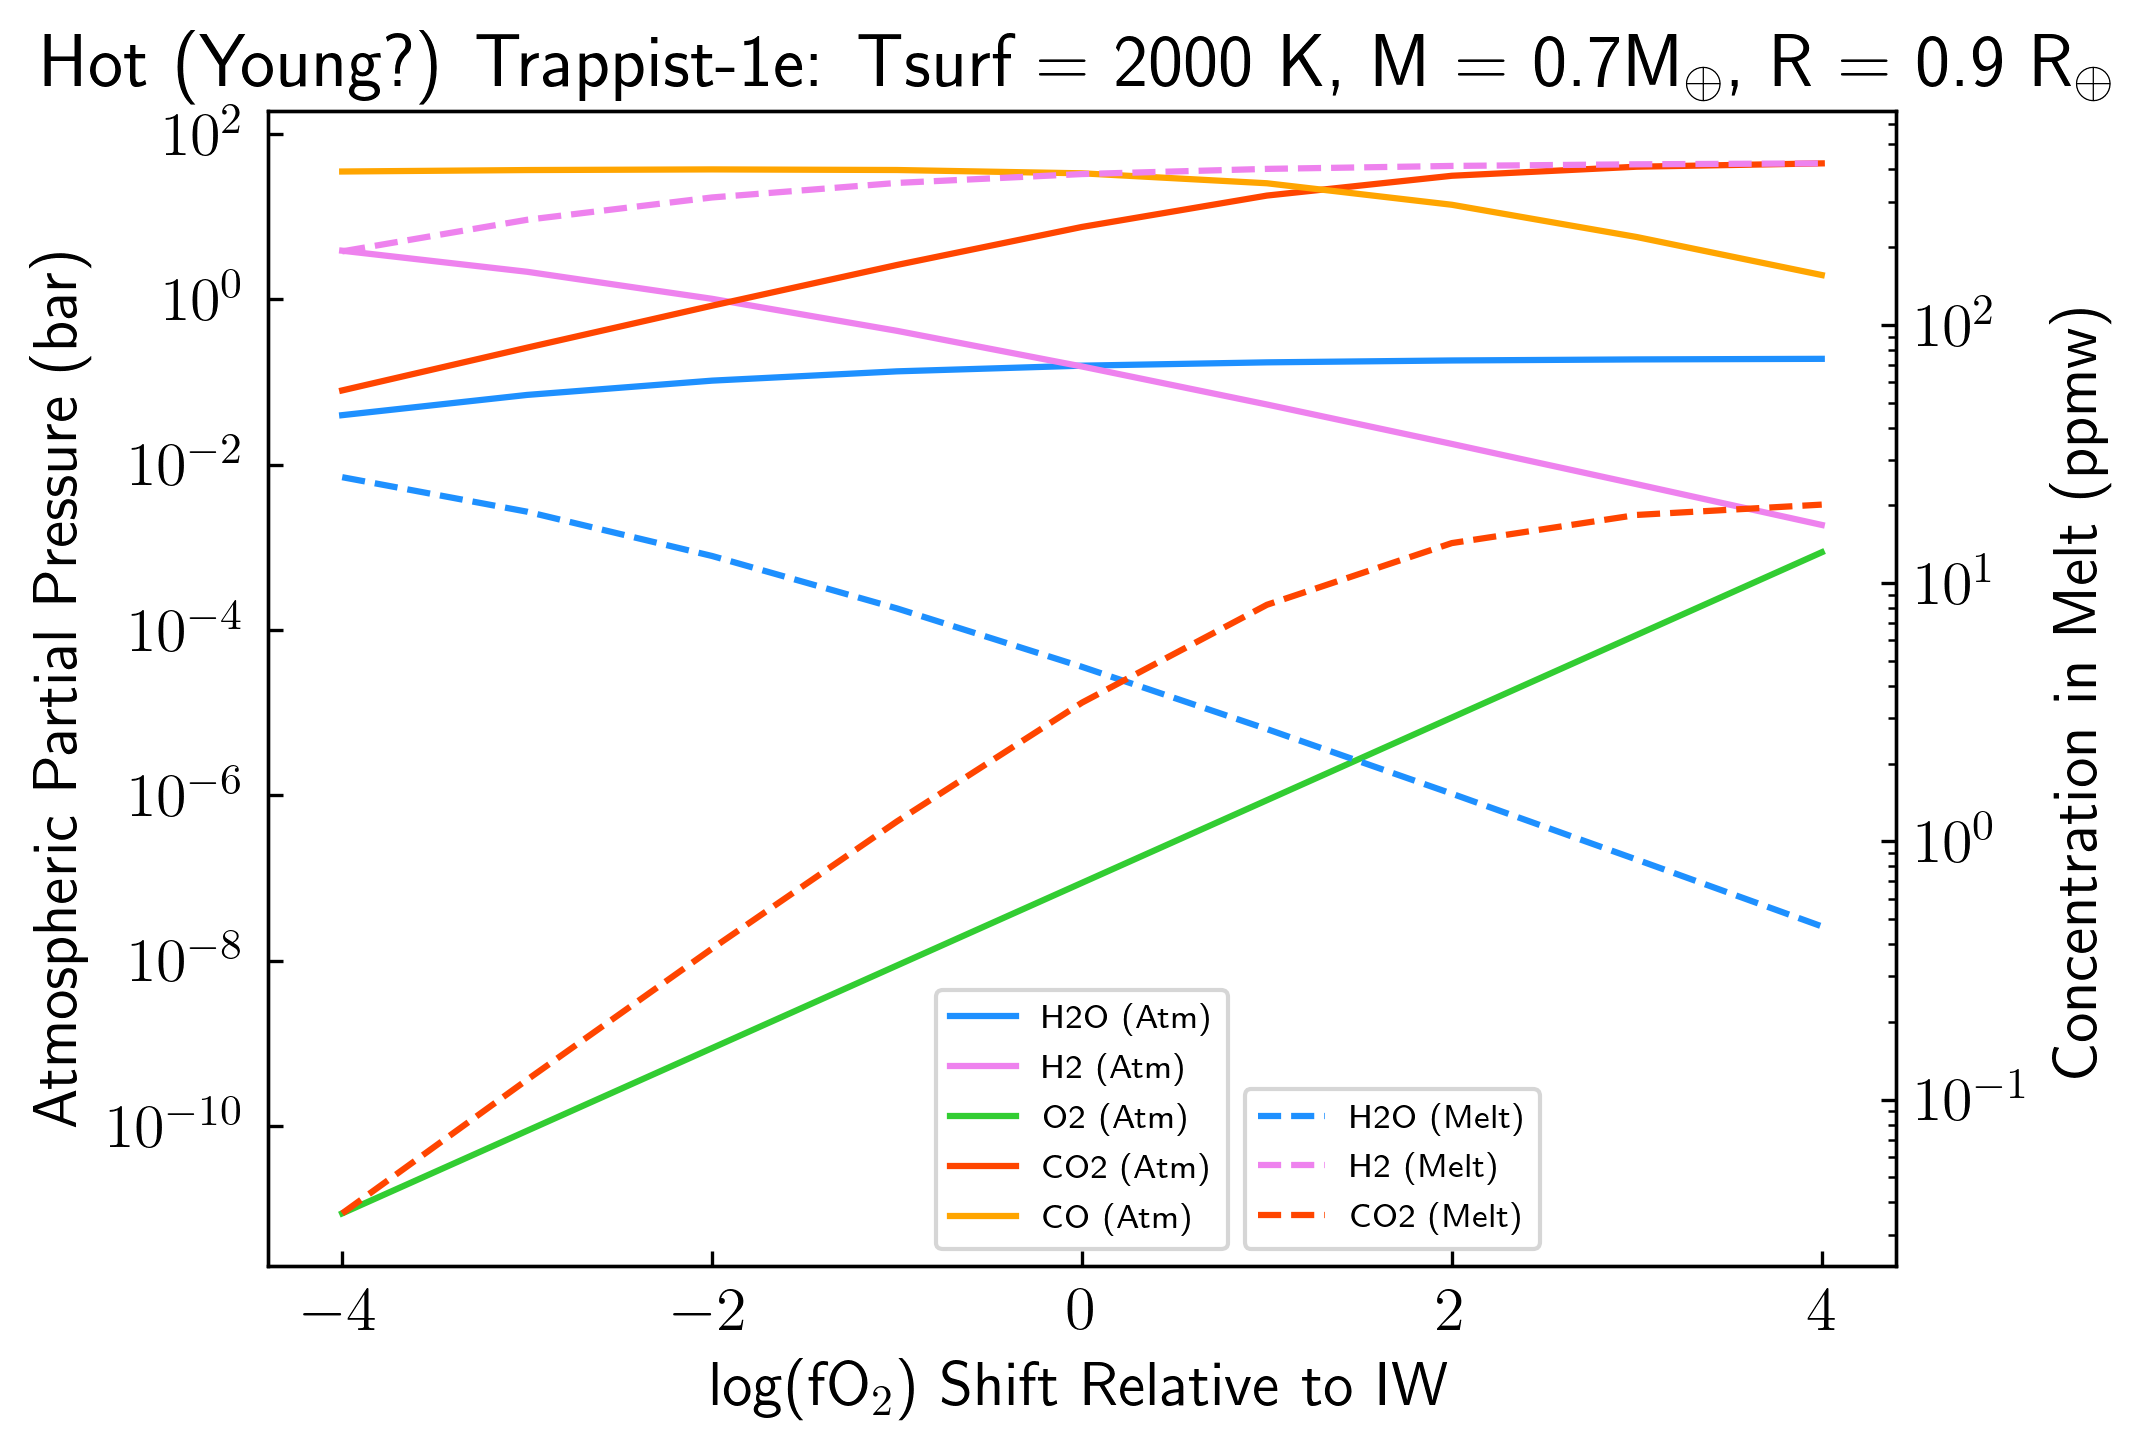

In [11]:
fig, ax = plt.subplots()
ax.plot(df_fO2.fO2_shift, df_fO2.H2O_pp, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.H2_pp, color='violet', label='H2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.O2_pp, color='limegreen', label='O2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO2_pp, color='orangered', label='CO2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO_pp, color='orange', label='CO (Atm)')

ax2 = ax.twinx()
ax2.plot(df_fO2.fO2_shift, df_fO2.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.CO_melt, color='orange', linestyle='--', label='CO (Melt)')

ax.set_xlabel(r'log(fO$_2$) Shift Relative to IW')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.legend(fontsize=8, loc=8)
ax2.legend(fontsize=8, loc=(0.6, 0.015))
plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 2000 K, M = 0.7M$_\oplus$, R = 0.9 R$_\oplus$')
#plt.savefig('data/Plots/PlanetTrial1_HotTrappist1e_CHO_2000K.jpg', dpi=1000)
plt.show()

## Simulating K2-18 b

In [14]:
planet: Planet = Planet(surface_temperature=1500, mantle_mass = 3.6315E25, surface_radius = 1.6647E7)
#planet: Planet = Planet()


In [15]:
species: Species = Species(
        [
            GasSpecies(
                chemical_formula="H2",
                solubility=BasaltH2(),
                thermodynamic_class=thermodynamic_data,
               # eos=IdealGas(),
            ),
            GasSpecies(
                chemical_formula="H2O",
                solubility=BasaltDixonH2O(),
                thermodynamic_class=thermodynamic_data,
               # eos=eos_models_HP["H2O"],
            ),
            GasSpecies(
                chemical_formula="O2",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["O2"]
            ),
            GasSpecies(
                chemical_formula="CO",
                solubility=BasaltCO(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO"],
            ),
            GasSpecies(
                chemical_formula="CO2",
                solubility=BasaltDixonCO2(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO2"],
            ),
            GasSpecies(
                chemical_formula="CH4",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CH4"],
            ),
        ]
    )

[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies


In [70]:
oceans: float = 10
h_kg: float = earth_oceans_to_kg(oceans)
c_kg: float = h_kg

constraints: SystemConstraints = SystemConstraints(
    [
        FugacityConstraint(species="H2", value=958),
        IronWustiteBufferConstraintHirschmann(),
        MassConstraint(species="C", value=c_kg),
    ]
)

system: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [71]:
initial_solution: np.ndarray = np.array([1000, 1000, 1e-8, 100, 10, 1])
system.solve(constraints, initial_solution=initial_solution)

In [72]:
system.output

{'temperature': 2000,
 'total_pressure_in_atmosphere': 2026.6981086063047,
 'mean_molar_mass_in_atmosphere': 0.010667466253504542,
 'H2': GasSpeciesOutput(mass_in_atmosphere=5.079421345277659e+21, mass_in_solid=0.0, mass_in_melt=1.6732962580062393e+22, moles_in_atmosphere=2.5197017212702226e+24, moles_in_melt=8.30056649152202e+24, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=460.7727545108741, fugacity=957.9999999999998, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=958.0000000000001, volume_mixing_ratio=0.47269003505351176, mass_in_total=2.1812383925340054e+22),
 'H2O': GasSpeciesOutput(mass_in_atmosphere=4.900071852467356e+22, mass_in_solid=0.0, mass_in_melt=1.1269436003070279e+24, moles_in_atmosphere=2.7199521453459807e+24, moles_in_melt=6.255485134969139e+25, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=31032.454916894614, fugacity=1034.1359587308082, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=1034.1359587308086, volume_mixing_ra

In [16]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [18]:
#Vary amount of H (expressed as Earth oceans)

number_of_realisations: int = 191

number_Earth_oceans_arr: np.ndarray = np.arange(1,16)

#print(number_Earth_oceans_arr)

#Vary abount of H in atmosphere:
H2_fugacity_arr: np.ndarray = np.arange(1000, 20100, 100)
print((float(H2_fugacity_arr[0])))

1000.0


In [71]:
#intial solution array:

CO2_fugacity_arr: np.ndarray = 5*np.ones(191)


191


In [19]:
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_C: float = earth_oceans_to_kg(10)
    H2_fug = H2_fugacity_arr[realisation]
    constraints: SystemConstraints = SystemConstraints([
        FugacityConstraint(species="H2", value=H2_fug),
        FugacityConstraint(species="CO2", value=5),
        IronWustiteBufferConstraintHirschmann()
    ])
    
    initial_solution: np.ndarray = np.array([H2_fug, 10000, 1e-12, 5, 5, 400])
    # Recall that changing attributes on the planet 'object' will be 'seen' by interior_atmosphere.
    interior_atmosphere.solve(constraints, factor=1, tol = 1e-6, initial_solution=initial_solution)
    #out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    
    H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    out_realisation: dict[str,float] = interior_atmosphere.solution_dict

    # Include the parameters in the output.

    out_realisation['H2_melt'] = H2_melt
    out_realisation['H2O_melt'] = H2O_melt
    out_realisation['O2_melt'] = O2_melt
    out_realisation['CO2_melt'] = CO2_melt
    out_realisation['CO_melt'] = CO_melt

    out_realisation['H2_fugacity'] = H2_fugacity_arr[realisation]

    out.append(out_realisation)

    filename: str = "data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)

Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/sci

SystemExit: 

/Users/maggiethompson/Programs/atmodeller/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
import pandas as pd
datafile_K218b_try: str = f"data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_RealGas_1500K.csv"
df_K218b_try: pd.DataFrame = pd.read_csv(datafile_K218b_try, skiprows=1, names=('H2','H2O','O2','CO','CO2','CH4','H2_melt','H2O_melt','O2_melt','CO2_melt','CO_melt','H2_fugacity'))

print(df_K218b_try)

               H2          H2O            O2         CO       CO2        CH4  \
0      727.090289   871.998239  2.875121e-12   8.958093  3.168227  42.060462   
1      777.359621   960.098892  2.910307e-12   8.557061  3.050008  48.282206   
2      824.746990  1047.884999  2.945157e-12   8.184113  2.939044  54.586422   
3      869.491261  1135.167414  2.979655e-12   7.836838  2.834786  60.940691   
4      911.792552  1221.912316  3.013810e-12   7.512805  2.736651  67.316499   
..            ...          ...           ...        ...       ...        ...   
186  45701.545874  1777.284296  1.376980e-10   0.000466  0.000252   0.032963   
187  45672.305072  1787.992747  1.374827e-10   0.000468  0.000253   0.033450   
188  45643.123591  1798.713155  1.372686e-10   0.000469  0.000253   0.033941   
189  45614.000747  1809.445494  1.370557e-10   0.000470  0.000254   0.034437   
190  20000.000000    10.000000  1.370557e-10  10.000000  5.000000  10.000000   

         H2_melt       H2O_melt  O2_mel

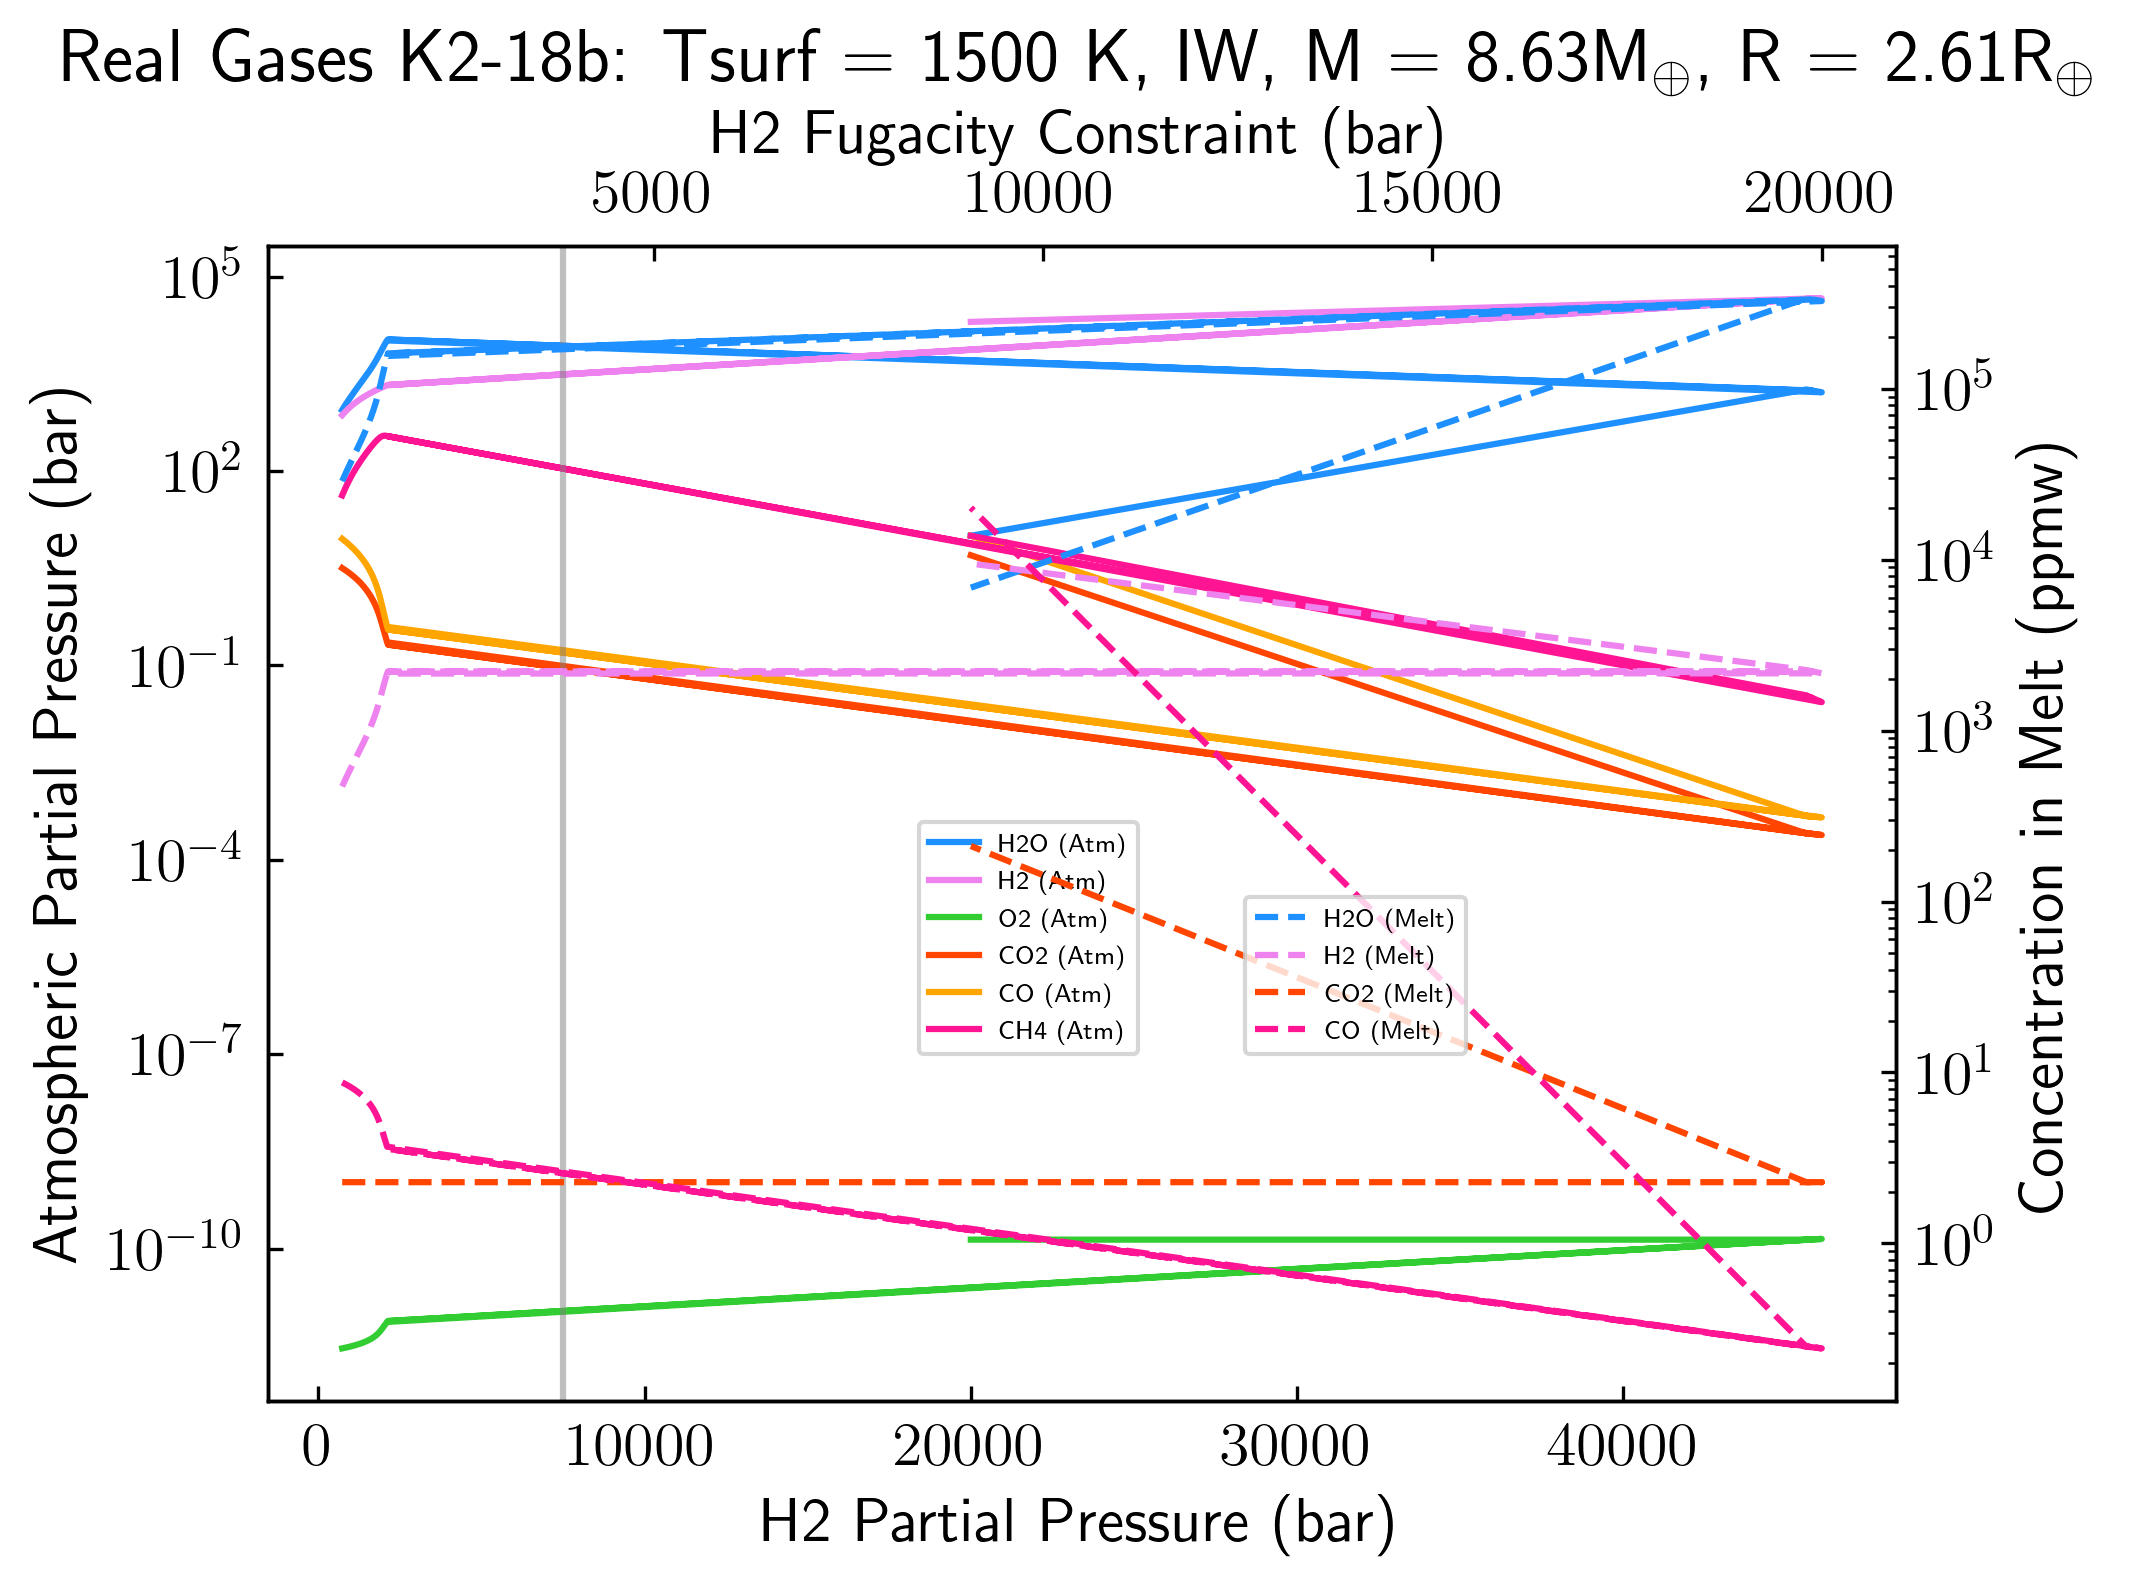

In [37]:
fig, ax = plt.subplots()
ax.plot(df_K218b_try.H2, df_K218b_try.H2O, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.H2, color='violet', label='H2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.O2, color='limegreen', label='O2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CO2, color='orangered', label='CO2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CO, color='orange', label='CO (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CH4, color='deeppink', label='CH4 (Atm)')


ax2 = ax.twinx()
ax2.plot(df_K218b_try.H2, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.CO_melt, color='deeppink', linestyle='--', label='CO (Melt)')
ax.axvline(x=7500, color='gray', alpha=0.5)
ax3 = ax.twiny()
ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2, alpha=0)
ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Partial Pressure (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax2.set_yscale('log')

ax.legend(fontsize=6, loc=(0.4, 0.3))
ax2.legend(fontsize=6, loc=(0.6, 0.3))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa.jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [28]:
print(df_K218b_try.CO)

0      7.273294
1      6.337788
2      5.565684
3      4.924222
4      4.387432
         ...   
186    0.114634
187    0.253518
188    0.094859
189    0.137936
190    0.284494
Name: CO, Length: 191, dtype: float64


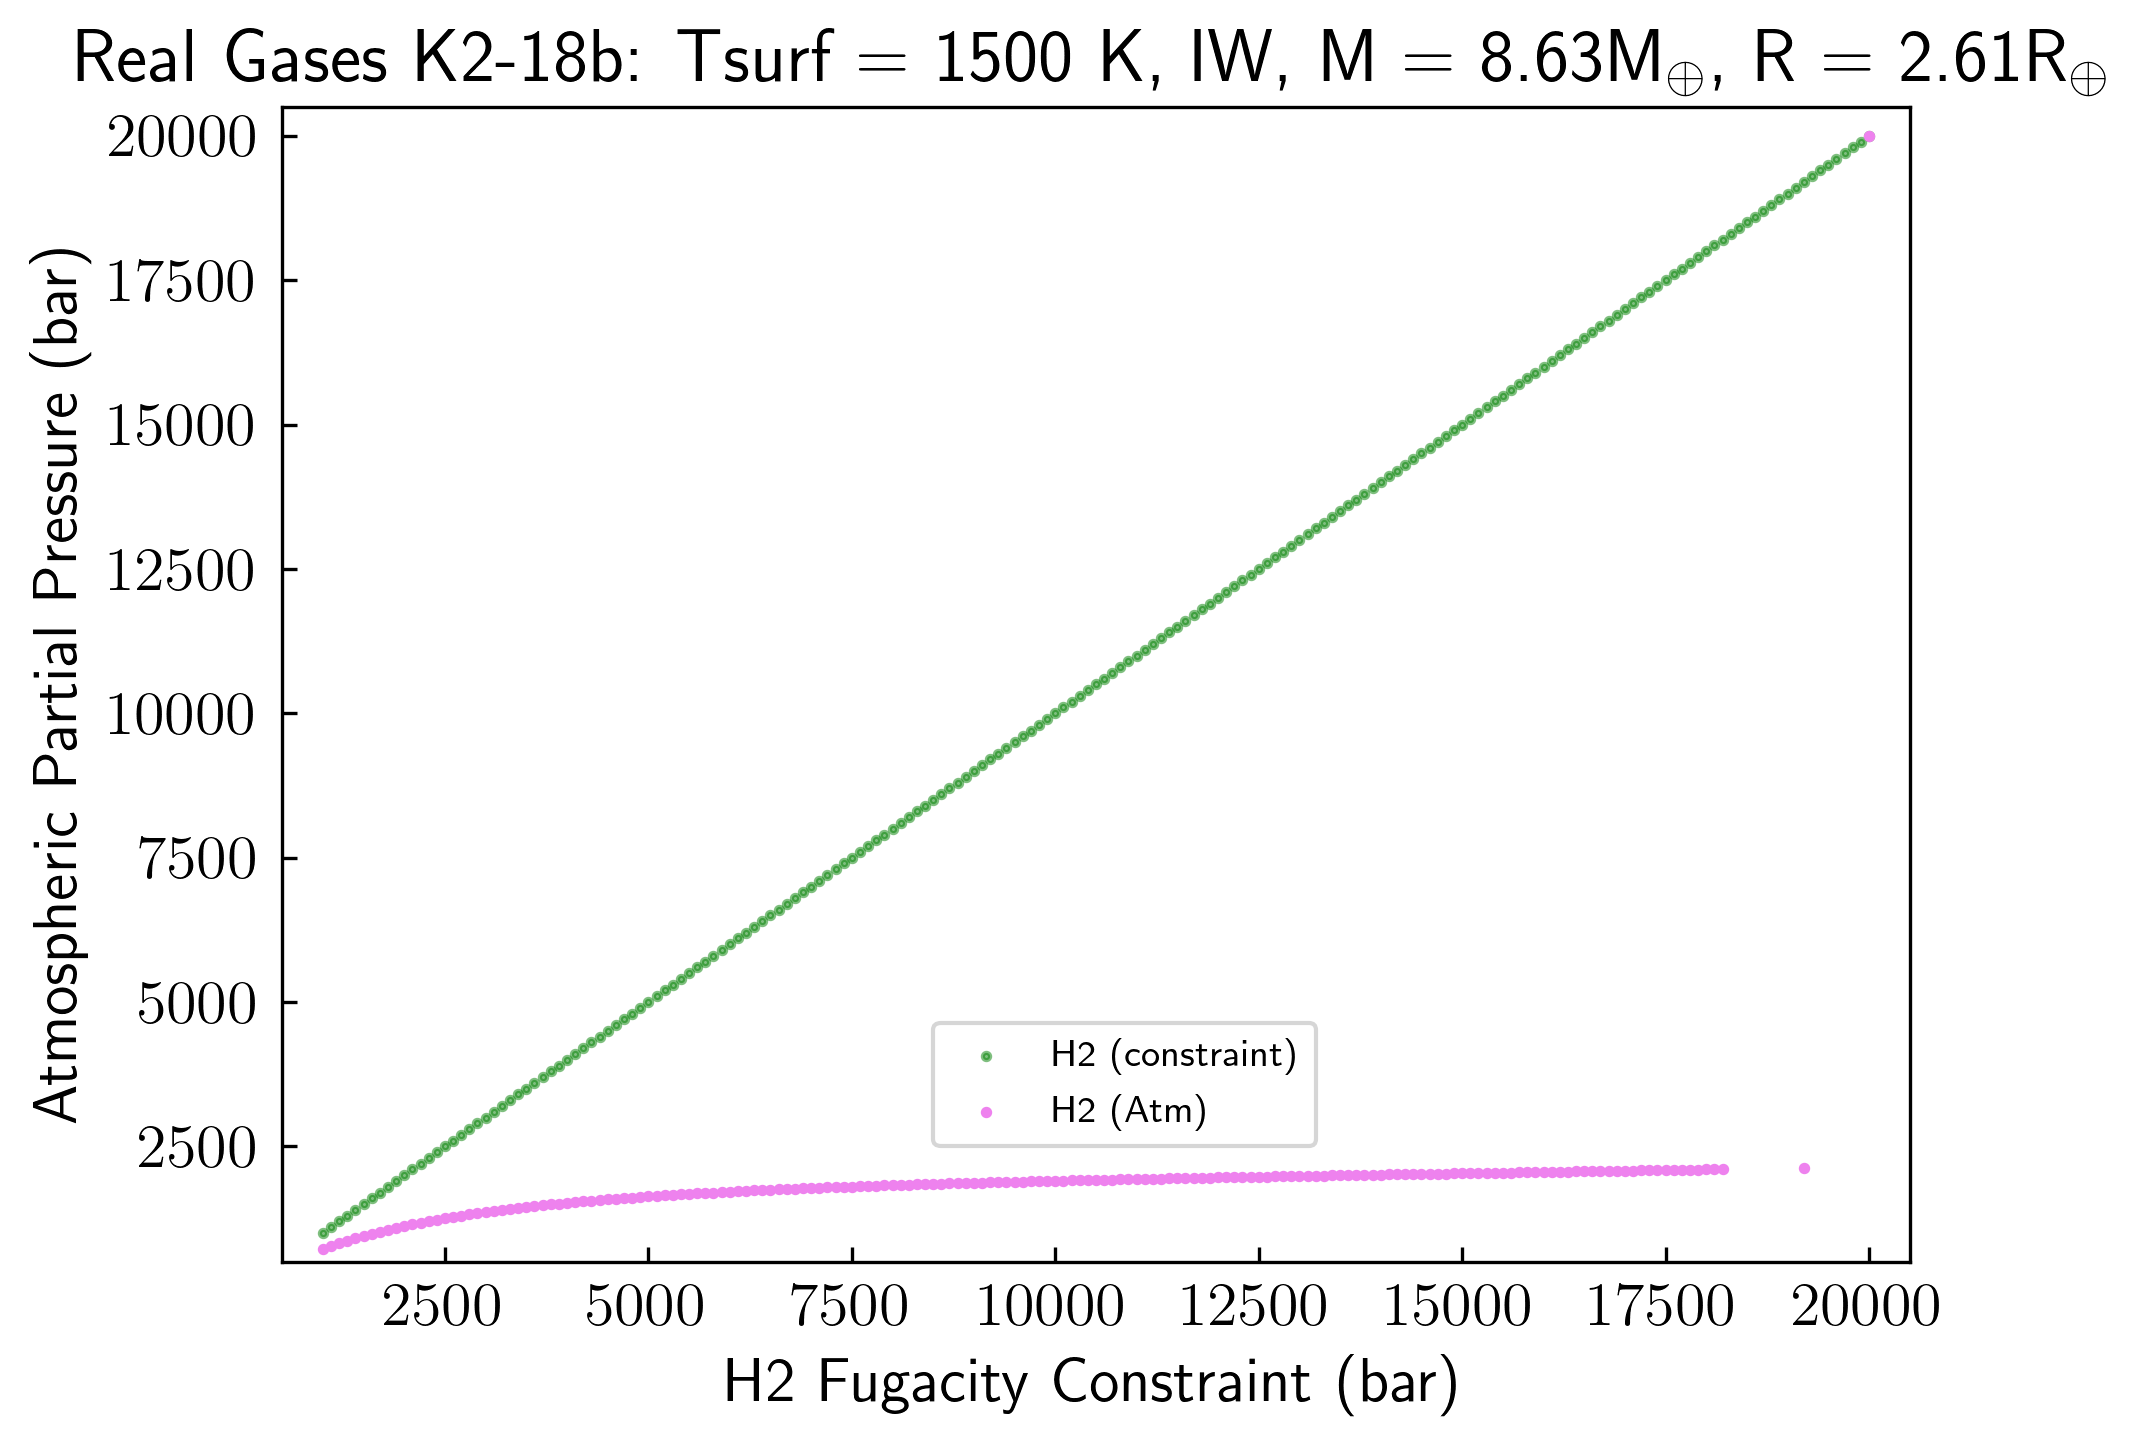

In [38]:
fig, ax = plt.subplots()
#ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2O, s=3, color='dodgerblue', label='H2O (Atm)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2_fugacity, s=3, color='green', alpha=0.5, label='H2 (constraint)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2, s=3, color='violet', label='H2 (Atm)')

#ax2 = ax.twinx()
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
ax.set_xlim(500,20500)
ax.set_ylim(500,20500)

#ax3 = ax.twiny()
#ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2)
#ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
#ax2.set_ylabel('Concentration in Melt (ppmw)')
#ax.set_yscale('log')
#ax2.set_yscale('log')

ax.legend(fontsize=9, loc=(0.4, 0.1))
ax2.legend(fontsize=6, loc=(0.6, 0.1))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa_H2Check_onlyFugacityConstraints.jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [2]:
import pandas as pd

T1e_NoSols = pd.ExcelFile('T1e_1500K_CHONS_AllIdeal_NoSols_3800.xlsx')
T1e_NoSols_atmo = pd.read_excel(T1e_NoSols, 'atmosphere')
T1e_NoSols_constraints = pd.read_excel(T1e_NoSols, 'constraints')
T1e_NoSols_planet = pd.read_excel(T1e_NoSols, 'planet')
T1e_NoSols_H2O = pd.read_excel(T1e_NoSols, 'H2O')
T1e_NoSols_H2 = pd.read_excel(T1e_NoSols, 'H2')
T1e_NoSols_O2 = pd.read_excel(T1e_NoSols, 'O2')
T1e_NoSols_CO = pd.read_excel(T1e_NoSols, 'CO')
T1e_NoSols_CO2 = pd.read_excel(T1e_NoSols, 'CO2')
T1e_NoSols_CH4 = pd.read_excel(T1e_NoSols, 'CH4')
T1e_NoSols_N2 = pd.read_excel(T1e_NoSols, 'N2')
T1e_NoSols_S2 = pd.read_excel(T1e_NoSols, 'S2')
T1e_NoSols_H2S = pd.read_excel(T1e_NoSols, 'H2S')
T1e_NoSols_SO2 = pd.read_excel(T1e_NoSols, 'SO2')
T1e_NoSols_SO = pd.read_excel(T1e_NoSols, 'SO')
T1e_NoSols_soln = pd.read_excel(T1e_NoSols, 'solution')
T1e_NoSols_constraints = pd.read_excel(T1e_NoSols, 'constraints')
T1e_NoSols_extra = pd.read_excel(T1e_NoSols, 'extra')





In [6]:

fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows=5)

colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=T1e_NoSols_extra.fO2_shift
#H2O-CO2
ax[0,0].scatter(T1e_NoSols_soln.H2O, T1e_NoSols_soln.CO2, c=colors, s=0.5)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('H2O (bar)')
ax[0,0].set_ylabel('CO2 (bar)')

#H2O-CO
ax[0,1].scatter(T1e_NoSols_soln.H2O, T1e_NoSols_soln.CO, c=colors, s=0.5)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('H2O (bar)')
ax[0,1].set_ylabel('CO (bar)')

#H2O-CH4
ax[0,2].scatter(T1e_NoSols_soln.H2O, T1e_NoSols_soln.CH4, c=colors, s=0.5)
ax[0,2].set_xscale('log')
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('H2O (bar)')
ax[0,2].set_ylabel('CH4 (bar)')

#H2O-H2
ax[0,3].scatter(T1e_NoSols_soln.H2O, T1e_NoSols_soln.H2, c=colors, s=0.5)
ax[0,3].set_xscale('log')
ax[0,3].set_yscale('log')
ax[0,3].set_xlabel('H2O (bar)')
ax[0,3].set_ylabel('H2 (bar)')

#H2O-N2
ax[0,4].scatter(T1e_NoSols_soln.H2O, T1e_NoSols_soln.N2, c=colors, s=0.5)
ax[0,4].set_xscale('log')
ax[0,4].set_yscale('log')
ax[0,4].set_xlabel('H2O (bar)')
ax[0,4].set_ylabel('N2 (bar)')

#CO2-CO
ax[1,0].scatter(T1e_NoSols_soln.CO2, T1e_NoSols_soln.CO, c=colors, s=0.5)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('CO2 (bar)')
ax[1,0].set_ylabel('CO (bar)')

#CO2-CH4
ax[1,1].scatter(T1e_NoSols_soln.CO2, T1e_NoSols_soln.CH4, c=colors, s=0.5)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('CO2 (bar)')
ax[1,1].set_ylabel('CH4 (bar)')

#CO2-H2
ax[1,2].scatter(T1e_NoSols_soln.CO2, T1e_NoSols_soln.H2, c=colors, s=0.5)
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')
ax[1,2].set_xlabel('CO2 (bar)')
ax[1,2].set_ylabel('H2 (bar)')

#CO2-N2
ax[1,3].scatter(T1e_NoSols_soln.CO2, T1e_NoSols_soln.N2, c=colors, s=0.5)
ax[1,3].set_xscale('log')
ax[1,3].set_yscale('log')
ax[1,3].set_xlabel('CO2 (bar)')
ax[1,3].set_ylabel('N2 (bar)')

#CO-CH4
ax[2,0].scatter(T1e_NoSols_soln.CO, T1e_NoSols_soln.CH4, c=colors, s=0.5)
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
ax[2,0].set_xlabel('CO (bar)')
ax[2,0].set_ylabel('CH4 (bar)')

#CO-H2
ax[2,1].scatter(T1e_NoSols_soln.CO, T1e_NoSols_soln.H2, c=colors, s=0.5)
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')
ax[2,1].set_xlabel('CO (bar)')
ax[2,1].set_ylabel('H2 (bar)')

#CO-N2
ax[2,2].scatter(T1e_NoSols_soln.CO, T1e_NoSols_soln.N2, c=colors, s=0.5)
ax[2,2].set_xscale('log')
ax[2,2].set_yscale('log')
ax[2,2].set_xlabel('CO (bar)')
ax[2,2].set_ylabel('N2 (bar)')

#CH4-H2
ax[3,0].scatter(T1e_NoSols_soln.CH4, T1e_NoSols_soln.H2, c=colors, s=0.5)
ax[3,0].set_xscale('log')
ax[3,0].set_yscale('log')
ax[3,0].set_xlabel('CH4 (bar)')
ax[3,0].set_ylabel('H2 (bar)')

#CH4-N2
ax[3,1].scatter(T1e_NoSols_soln.CH4, T1e_NoSols_soln.N2, c=colors, s=0.5)
ax[3,1].set_xscale('log')
ax[3,1].set_yscale('log')
ax[3,1].set_xlabel('CH4 (bar)')
ax[3,1].set_ylabel('N2 (bar)')

#H2-N2
sc = ax[4,0].scatter(T1e_NoSols_soln.H2, T1e_NoSols_soln.N2, c=colors, s=0.5)
ax[4,0].set_xscale('log')
ax[4,0].set_yscale('log')
ax[4,0].set_xlabel('H2 (bar)')
ax[4,0].set_ylabel('N2 (bar)')

ax[1, 4].axis('off')
ax[2, 3].axis('off')
ax[2, 4].axis('off')
ax[3, 2].axis('off')
ax[3, 3].axis('off')
ax[3, 4].axis('off')
ax[4, 1].axis('off')
ax[4, 2].axis('off')
ax[4, 3].axis('off')
ax[4, 4].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.05, 0.5])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')

fig.tight_layout()
#plt.savefig("Plots/T1e_HCON_1500K_MF1_3800_logscale.jpg", dpi=1000)
plt.show()

/var/folders/48/rykhh41s6ds_xk4143_5pyv00000gn/T/ipykernel_10670/2482976497.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
/var/folders/48/rykhh41s6ds_xk4143_5pyv00000gn/T/ipykernel_10670/2482976497.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

Error in callback <function _draw_all_if_interactive at 0x113b8de40> (for post_execute):


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

<Figure size 4500x4500 with 26 Axes>